Make sure your runtime type is set to GPU rather than CPU. Then we install JAXFit with pip

In [1]:
!pip install jaxfit 

Looking in indexes: https://test.pypi.org/simple/, https://us-python.pkg.dev/colab-wheels/public/simple/


Import JAXFit before importing JAX since we need JAXFit to set all the JAX computation to use 64 rather than 32 bit arrays.

In [2]:
from jaxfit import CurveFit
import jax.numpy as jnp

Now let's define a 2D Gaussian using jax.numpy. You can construct function just like numpy with a few small caveats (see **).

In [3]:
def rotate_coordinates2D(coords, theta):
    R = jnp.array([[jnp.cos(theta), -jnp.sin(theta)],
                  [jnp.sin(theta), jnp.cos(theta)]])
  
    shape = coords[0].shape
    coords = jnp.stack([coord.flatten() for coord in coords])
    rcoords = R @ coords
    return [jnp.reshape(coord, shape) for coord in rcoords]


def gaussian2d(coords, n0, x0, y0, sigma_x, sigma_y, theta, offset):
    coords = [coords[0] - x0, coords[1] - y0] #translate first
    X, Y = rotate_coordinates2D(coords, theta)
    density = n0 * jnp.exp(-.5 * (X**2 / sigma_x**2 + Y**2 / sigma_y**2))
    return density + offset

Using the function we just created, we'll simulate some synthetic fit data and show what it looks like.

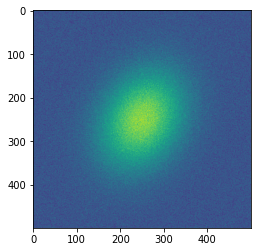

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time

def get_coordinates(width, height):
    x = np.linspace(0, width - 1, width)
    y = np.linspace(0, height - 1, height)
    X, Y = np.meshgrid(x, y)
    return X, Y


def get_gaussian_parameters(length):
  n0 = 1
  x0 = length / 2
  y0 = length / 2
  sigx = length / 6
  sigy = length / 8
  theta = np.pi / 3

  offset = .1 * n0
  params = [n0, x0, y0, sigx, sigy, theta, offset]
  return params

length = 500
XY_tuple = get_coordinates(length, length)

params = get_gaussian_parameters(length)
zdata = gaussian2d(XY_tuple, *params)
zdata += np.random.normal(0, .1, size=(length, length))

plt.imshow(zdata)
plt.show()

Now we initialize the JAXFit CurveFit object and then fit our synthetic data 100 times with a different random seed for each fit.

In [5]:
from scipy.optimize import curve_fit

def get_random_float(low, high):
    delta = high - low
    return low + delta * np.random.random()

flat_data = zdata.flatten()
flat_XY_tuple = [coord.flatten() for coord in XY_tuple]
jcf = CurveFit()

loop = 100
times = []
stimes = []
for i in range(loop):
    print(i, 'of', loop)
    seed = [val * get_random_float(.9, 1.2) for val in params]
    st = time.time()
    popt, pcov = jcf.curve_fit(gaussian2d, flat_XY_tuple, flat_data, p0=seed)
    times.append(time.time() - st)

popt2, pcov2 = curve_fit(gaussian2d, flat_XY_tuple, flat_data, p0=seed)

0 of 100
1 of 100
2 of 100
3 of 100
4 of 100
5 of 100
6 of 100
7 of 100
8 of 100
9 of 100
10 of 100
11 of 100
12 of 100
13 of 100
14 of 100
15 of 100
16 of 100
17 of 100
18 of 100
19 of 100
20 of 100
21 of 100
22 of 100
23 of 100
24 of 100
25 of 100
26 of 100
27 of 100
28 of 100
29 of 100
30 of 100
31 of 100
32 of 100
33 of 100
34 of 100
35 of 100
36 of 100
37 of 100
38 of 100
39 of 100
40 of 100
41 of 100
42 of 100
43 of 100
44 of 100
45 of 100
46 of 100
47 of 100
48 of 100
49 of 100
50 of 100
51 of 100
52 of 100
53 of 100
54 of 100
55 of 100
56 of 100
57 of 100
58 of 100
59 of 100
60 of 100
61 of 100
62 of 100
63 of 100
64 of 100
65 of 100
66 of 100
67 of 100
68 of 100
69 of 100
70 of 100
71 of 100
72 of 100
73 of 100
74 of 100
75 of 100
76 of 100
77 of 100
78 of 100
79 of 100
80 of 100
81 of 100
82 of 100
83 of 100
84 of 100
85 of 100
86 of 100
87 of 100
88 of 100
89 of 100
90 of 100
91 of 100
92 of 100
93 of 100
94 of 100
95 of 100
96 of 100
97 of 100
98 of 100
99 of 100


Let's see how fast these fits were done and how they compare to SciPy in accuracy.

Average fit time 0.046515048152268534
JAXFit parameters [1.00252867e+00 2.49974134e+02 2.49931782e+02 8.32342717e+01
 6.25044482e+01 1.05233639e+00 9.92328574e-02]
SciPy parameters [1.00252867e+00 2.49974134e+02 2.49931782e+02 8.32342717e+01
 6.25044482e+01 1.05233639e+00 9.92328574e-02]


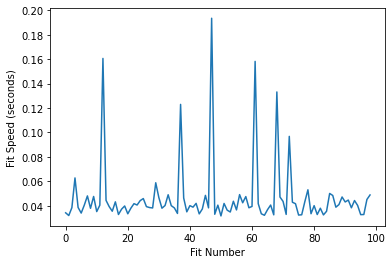

In [6]:
print('Average fit time', np.mean(times[1:]))
print('JAXFit parameters', popt)
print('SciPy parameters', popt2)

plt.figure()
plt.plot(times[1:])
plt.xlabel('Fit Number')
plt.ylabel('Fit Speed (seconds)')
plt.show()

ooo so speedy

In [ ]:
# jcf = CurveFit(flength=length**2)